In [1]:
import numpy as np
import pandas as pd
import json
import random

n = 15
customer = [i for i in range(1, n + 1)]
node = [0] + customer
arcos = [(i,j) for i in node for j in node if i != j]
f = open('pelanggan.json')
data = json.load(f)
# get customer demand and location data
df = pd.DataFrame(data)
# print(df)
# get distance data
distance = np.loadtxt('distance.txt')
vehicle_capacity = 250
demand = df.demand

In [5]:
default = 0.5
Q = np.zeros((len(node),len(node)))
for i in range(len(node)):
    for j in range(len(node)):
        if(i!=j):
            Q[i][j] = default
DA = np.array([0])
np.savetxt('Q.txt', Q)
np.savetxt('DA.txt',DA)

In [6]:
miu = 0.05
diskon = 0.9
epsilon = 0.01

def bestq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    max_value = np.max(curr_qtable)
    result = np.where(curr_qtable == max_value)[0]
    if(len(result) == 1):
        return node[result[0]]
    else:
        rnd = random.randint(0,len(result)-1)
        return node[result[rnd]]
#         curr_distance = np.copy(distance[i][node, ])
#         curr_distance = np.copy(curr_distance[result, ])
#         min_distance = np.min(curr_distance)
#         result_distance = np.where(curr_distance == min_distance)
#         return node[result_distance[0]][0]

def randomq(node):
    result = random.randint(0,len(node)-1)
    return node[result]

def maxq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    max_value = np.max(curr_qtable)
    return max_value

def minq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    min_value = np.min(curr_qtable)
    return min_value

def countDistance(route):
    total = 0
    for n in range(len(route)):
        total+=distance[route[n][0]][route[n][1]]
    return total

def updateQ(Q, route, nodes):
    DA = np.loadtxt('DA.txt')
    total = countDistance(route) / ( len(route) - 1)
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        DAnew = DA
    else:
        DAnew = ( DA + total ) / 2
    if(DA>total):
        r = 1
    else:
        r = 0
    #End Fungsi untuk Reward
    Qnew = np.copy(Q)
    for n in range(len(route) - 1):
        i = route[n][0]
        j = route[n][1]
        Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * minq(Q,nodes[n],j) ) - Q[i][j] ) )
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DAnew]))

In [11]:
MaxEpisode = 500
episode = 0
cek1 = []
cek2 = []

while(episode < MaxEpisode):
    Q = np.loadtxt('Q.txt')
    nodes = np.array(node)
    nodes = np.delete(nodes, [0])
    capacity = vehicle_capacity
    route = 1
    routes = []
    rnode = []
    croute = []
    i = 0
    total_dis = 0
    while(len(nodes)>0):
        greed = random.random()
        if(len(nodes) == 1):
            j = nodes[0]
            if (capacity - demand[j]) < 0 :
                routes.append([i,0])
                rnode.append(  np.insert(np.copy(nodes), 0, 0) )
                updateQ(Q, routes, rnode)
                croute.append(routes)
                #
                total_dis+=countDistance(routes)
                #
                i = 0
                routes = []
                rnode = []
                route += 1                
            routes.append([i,j])
            routes.append([j,0]) 
            rnode.append(  np.insert(np.copy(nodes), 0, 0) )
            updateQ(Q, routes, rnode)
            croute.append(routes)
            #
            total_dis+=countDistance(routes)
            #
            i = 0
            routes = []
            rnode = []
            route += 1  
            break
        if greed < epsilon :
            #Exploration Move
            j = randomq(nodes)
        else:
            #Exploitation Move
            j = bestq(Q, nodes, i)
        if (capacity - demand[j]) > 0 :
            routes.append([i,j])
            rnode.append( np.insert(np.copy(nodes), 0, 0) )
            getndex = np.where(nodes == j)[0]
            nodes = np.delete(nodes, [getndex])
            capacity -= demand[j]
            i = j
        else:
            routes.append([i,0])
            rnode.append( np.insert(np.copy(nodes), 0, 0) )
            updateQ(Q, routes, rnode)
            croute.append(routes)
            #
            total_dis+=countDistance(routes)
            #
            i = 0
            routes = []
            rnode = []
            route += 1
            capacity = vehicle_capacity

    print("Episode : "+str(episode))
    cek1.append(episode)
    cek2.append(total_dis)
    for n in range(route - 1):
        print("Rute "+str(n)+" : "+str(croute[n]))
    episode += 1
    print("Total Distace : "+str(total_dis))
    print("-------------------------")    

Episode : 0
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 6], [6, 9], [9, 14], [14, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 13], [13, 3], [3, 11], [11, 7], [7, 0]]
Rute 2 : [[0, 12], [12, 5], [5, 0]]
Total Distace : 41154.0
-------------------------
Episode : 1
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 15], [15, 14], [14, 0]]
Rute 1 : [[0, 11], [11, 7], [7, 13], [13, 6], [6, 9], [9, 3], [3, 5], [5, 0]]
Rute 2 : [[0, 12], [12, 0]]
Total Distace : 32964.0
-------------------------
Episode : 2
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 1], [1, 15], [15, 10], [10, 14], [14, 0]]
Rute 1 : [[0, 11], [11, 7], [7, 13], [13, 6], [6, 9], [9, 3], [3, 5], [5, 0]]
Rute 2 : [[0, 12], [12, 0]]
Total Distace : 38297.0
-------------------------
Episode : 3
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 1], [1, 15], [15, 9], [9, 7], [7, 13], [13, 0]]
Rute 1 : [[0, 10], [10, 5], [5, 3], [3, 11], [11, 6], [6, 14], [14, 0]]
Rute 2 : [[0, 12], [12, 0]]
Total Distace : 38971.0
-------------------------
Episode 

Episode : 34
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 15], [15, 14], [14, 0]]
Rute 1 : [[0, 13], [13, 6], [6, 3], [3, 11], [11, 7], [7, 9], [9, 0]]
Rute 2 : [[0, 5], [5, 12], [12, 0]]
Total Distace : 41423.0
-------------------------
Episode : 35
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 1], [1, 15], [15, 10], [10, 3], [3, 0]]
Rute 1 : [[0, 13], [13, 6], [6, 11], [11, 7], [7, 9], [9, 14], [14, 0]]
Rute 2 : [[0, 12], [12, 5], [5, 0]]
Total Distace : 42088.0
-------------------------
Episode : 36
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 15], [15, 12], [12, 0]]
Rute 1 : [[0, 13], [13, 6], [6, 14], [14, 9], [9, 7], [7, 3], [3, 0]]
Rute 2 : [[0, 11], [11, 5], [5, 0]]
Total Distace : 44801.0
-------------------------
Episode : 37
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 12], [12, 6], [6, 10], [10, 0]]
Rute 1 : [[0, 13], [13, 3], [3, 11], [11, 7], [7, 15], [15, 14], [14, 1], [1, 0]]
Rute 2 : [[0, 9], [9, 5], [5, 0]]
Total Distace : 37420.0
-------------------------
Epis

Episode : 69
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 1], [1, 15], [15, 14], [14, 6], [6, 0]]
Rute 1 : [[0, 10], [10, 3], [3, 13], [13, 11], [11, 9], [9, 7], [7, 0]]
Rute 2 : [[0, 5], [5, 12], [12, 0]]
Total Distace : 40387.0
-------------------------
Episode : 70
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 6], [6, 14], [14, 11], [11, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 3], [3, 9], [9, 13], [13, 0]]
Rute 2 : [[0, 7], [7, 5], [5, 12], [12, 0]]
Total Distace : 37890.0
-------------------------
Episode : 71
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 1], [1, 15], [15, 10], [10, 0]]
Rute 1 : [[0, 13], [13, 6], [6, 14], [14, 9], [9, 11], [11, 7], [7, 0]]
Rute 2 : [[0, 12], [12, 5], [5, 0]]
Total Distace : 41327.0
-------------------------
Episode : 72
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 11], [11, 10], [10, 1], [1, 0]]
Rute 1 : [[0, 3], [3, 15], [15, 9], [9, 6], [6, 7], [7, 13], [13, 12], [12, 0]]
Rute 2 : [[0, 14], [14, 5], [5, 0]]
Total Distace : 37743.0
-------------------------
Epis

Episode : 102
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 3], [3, 0]]
Rute 1 : [[0, 13], [13, 6], [6, 15], [15, 9], [9, 11], [11, 14], [14, 0]]
Rute 2 : [[0, 7], [7, 12], [12, 5], [5, 0]]
Total Distace : 39517.0
-------------------------
Episode : 103
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 6], [6, 11], [11, 3], [3, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 13], [13, 12], [12, 9], [9, 0]]
Rute 2 : [[0, 14], [14, 7], [7, 5], [5, 0]]
Total Distace : 39726.0
-------------------------
Episode : 104
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 13], [13, 6], [6, 10], [10, 0]]
Rute 1 : [[0, 15], [15, 14], [14, 1], [1, 9], [9, 11], [11, 7], [7, 0]]
Rute 2 : [[0, 12], [12, 5], [5, 0]]
Total Distace : 38855.0
-------------------------
Episode : 105
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 15], [15, 13], [13, 0]]
Rute 1 : [[0, 3], [3, 14], [14, 11], [11, 6], [6, 9], [9, 7], [7, 0]]
Rute 2 : [[0, 5], [5, 12], [12, 0]]
Total Distace : 43051.0
-------------------------


Episode : 140
Rute 0 : [[0, 8], [8, 4], [4, 5], [5, 3], [3, 13], [13, 6], [6, 9], [9, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 14], [14, 2], [2, 7], [7, 0]]
Rute 2 : [[0, 11], [11, 12], [12, 0]]
Total Distace : 36983.0
-------------------------
Episode : 141
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 1], [1, 15], [15, 12], [12, 11], [11, 0]]
Rute 1 : [[0, 10], [10, 14], [14, 3], [3, 13], [13, 6], [6, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 5], [5, 0]]
Total Distace : 43136.0
-------------------------
Episode : 142
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 1], [1, 15], [15, 13], [13, 6], [6, 0]]
Rute 1 : [[0, 10], [10, 3], [3, 11], [11, 14], [14, 9], [9, 0]]
Rute 2 : [[0, 7], [7, 12], [12, 5], [5, 0]]
Total Distace : 39684.0
-------------------------
Episode : 143
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 15], [15, 14], [14, 0]]
Rute 1 : [[0, 13], [13, 6], [6, 3], [3, 11], [11, 9], [9, 7], [7, 0]]
Rute 2 : [[0, 5], [5, 12], [12, 0]]
Total Distace : 41589.0
-------------------------


Episode : 174
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 13], [13, 6], [6, 9], [9, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 12], [12, 11], [11, 14], [14, 0]]
Rute 2 : [[0, 7], [7, 5], [5, 0]]
Total Distace : 42402.0
-------------------------
Episode : 175
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 15], [15, 14], [14, 10], [10, 0]]
Rute 1 : [[0, 13], [13, 6], [6, 9], [9, 11], [11, 1], [1, 7], [7, 0]]
Rute 2 : [[0, 5], [5, 12], [12, 0]]
Total Distace : 39100.0
-------------------------
Episode : 176
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 14], [14, 13], [13, 6], [6, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 3], [3, 15], [15, 12], [12, 11], [11, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 5], [5, 0]]
Total Distace : 35808.0
-------------------------
Episode : 177
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 11], [11, 6], [6, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 14], [14, 13], [13, 12], [12, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 5], [5, 0]]
Total Distace : 36605.0
-------------------------


Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 1], [1, 15], [15, 13], [13, 11], [11, 0]]
Rute 1 : [[0, 10], [10, 7], [7, 14], [14, 6], [6, 9], [9, 0]]
Rute 2 : [[0, 12], [12, 5], [5, 0]]
Total Distace : 35415.0
-------------------------
Episode : 211
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 15], [15, 14], [14, 11], [11, 13], [13, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 9], [9, 6], [6, 0]]
Rute 2 : [[0, 7], [7, 12], [12, 5], [5, 0]]
Total Distace : 35371.0
-------------------------
Episode : 212
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 15], [15, 13], [13, 0]]
Rute 1 : [[0, 3], [3, 14], [14, 11], [11, 6], [6, 9], [9, 7], [7, 0]]
Rute 2 : [[0, 5], [5, 12], [12, 0]]
Total Distace : 43051.0
-------------------------
Episode : 213
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 11], [11, 10], [10, 0]]
Rute 1 : [[0, 13], [13, 1], [1, 15], [15, 12], [12, 14], [14, 6], [6, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 5], [5, 0]]
Total Distace : 40929.0
-------------------------
Episode : 214


Episode : 245
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 14], [14, 3], [3, 11], [11, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 13], [13, 6], [6, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 12], [12, 5], [5, 0]]
Total Distace : 39476.0
-------------------------
Episode : 246
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 12], [12, 14], [14, 3], [3, 13], [13, 11], [11, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 5], [5, 6], [6, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 0]]
Total Distace : 38853.0
-------------------------
Episode : 247
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 6], [6, 15], [15, 14], [14, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 11], [11, 3], [3, 13], [13, 12], [12, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 5], [5, 0]]
Total Distace : 40322.0
-------------------------
Episode : 248
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 14], [14, 3], [3, 15], [15, 12], [12, 13], [13, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 9], [9, 6], [6, 0]]
Rute 2 : [[0, 11], [11, 7], [7, 5], [5, 0]]
Total Distace : 38150.0
-------------------------


Episode : 280
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 13], [13, 10], [10, 1], [1, 0]]
Rute 1 : [[0, 15], [15, 14], [14, 6], [6, 9], [9, 11], [11, 7], [7, 0]]
Rute 2 : [[0, 12], [12, 5], [5, 0]]
Total Distace : 40170.0
-------------------------
Episode : 281
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 7], [7, 15], [15, 13], [13, 12], [12, 9], [9, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 14], [14, 3], [3, 11], [11, 0]]
Rute 2 : [[0, 6], [6, 5], [5, 0]]
Total Distace : 40513.0
-------------------------
Episode : 282
Rute 0 : [[0, 9], [9, 6], [6, 3], [3, 1], [1, 15], [15, 12], [12, 0]]
Rute 1 : [[0, 8], [8, 4], [4, 2], [2, 7], [7, 13], [13, 11], [11, 10], [10, 0]]
Rute 2 : [[0, 14], [14, 5], [5, 0]]
Total Distace : 40090.0
-------------------------
Episode : 283
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 11], [11, 13], [13, 10], [10, 0]]
Rute 1 : [[0, 3], [3, 15], [15, 12], [12, 6], [6, 14], [14, 1], [1, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 5], [5, 0]]
Total Distace : 41971.0
-------------------------


Episode : 313
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 13], [13, 11], [11, 15], [15, 12], [12, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 9], [9, 6], [6, 3], [3, 0]]
Rute 2 : [[0, 14], [14, 7], [7, 5], [5, 0]]
Total Distace : 40857.0
-------------------------
Episode : 314
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 11], [11, 14], [14, 13], [13, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 12], [12, 3], [3, 9], [9, 0]]
Rute 2 : [[0, 6], [6, 7], [7, 5], [5, 0]]
Total Distace : 38035.0
-------------------------
Episode : 315
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 6], [6, 13], [13, 11], [11, 15], [15, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 3], [3, 14], [14, 9], [9, 0]]
Rute 2 : [[0, 12], [12, 7], [7, 5], [5, 0]]
Total Distace : 39613.0
-------------------------
Episode : 316
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 15], [15, 14], [14, 3], [3, 11], [11, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 13], [13, 6], [6, 12], [12, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 5], [5, 0]]
Total Distace : 38588.0
-------------------------


Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 11], [11, 10], [10, 1], [1, 0]]
Rute 1 : [[0, 15], [15, 3], [3, 13], [13, 6], [6, 14], [14, 9], [9, 12], [12, 0]]
Rute 2 : [[0, 7], [7, 5], [5, 0]]
Total Distace : 41747.0
-------------------------
Episode : 349
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 6], [6, 13], [13, 10], [10, 0]]
Rute 1 : [[0, 15], [15, 14], [14, 11], [11, 3], [3, 1], [1, 9], [9, 0]]
Rute 2 : [[0, 12], [12, 7], [7, 5], [5, 0]]
Total Distace : 35245.0
-------------------------
Episode : 350
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 11], [11, 6], [6, 13], [13, 3], [3, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 14], [14, 9], [9, 0]]
Rute 2 : [[0, 12], [12, 7], [7, 5], [5, 0]]
Total Distace : 37323.0
-------------------------
Episode : 351
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 15], [15, 12], [12, 0]]
Rute 1 : [[0, 13], [13, 11], [11, 3], [3, 14], [14, 6], [6, 9], [9, 0]]
Rute 2 : [[0, 5], [5, 7], [7, 0]]
Total Distace : 41334.0
-------------------------
Episode : 352


Episode : 381
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 3], [3, 1], [1, 15], [15, 10], [10, 0]]
Rute 1 : [[0, 13], [13, 11], [11, 14], [14, 6], [6, 9], [9, 12], [12, 0]]
Rute 2 : [[0, 5], [5, 7], [7, 0]]
Total Distace : 41917.0
-------------------------
Episode : 382
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 14], [14, 11], [11, 3], [3, 1], [1, 0]]
Rute 1 : [[0, 10], [10, 7], [7, 15], [15, 13], [13, 6], [6, 9], [9, 0]]
Rute 2 : [[0, 12], [12, 5], [5, 0]]
Total Distace : 37977.0
-------------------------
Episode : 383
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 15], [15, 14], [14, 0]]
Rute 1 : [[0, 13], [13, 3], [3, 11], [11, 6], [6, 12], [12, 9], [9, 0]]
Rute 2 : [[0, 7], [7, 5], [5, 0]]
Total Distace : 40258.0
-------------------------
Episode : 384
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 12], [12, 13], [13, 10], [10, 1], [1, 0]]
Rute 1 : [[0, 15], [15, 3], [3, 14], [14, 6], [6, 11], [11, 9], [9, 0]]
Rute 2 : [[0, 5], [5, 7], [7, 0]]
Total Distace : 37879.0
-------------------------


Episode : 414
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 15], [15, 12], [12, 10], [10, 1], [1, 0]]
Rute 1 : [[0, 13], [13, 3], [3, 11], [11, 6], [6, 14], [14, 9], [9, 0]]
Rute 2 : [[0, 5], [5, 7], [7, 0]]
Total Distace : 44045.0
-------------------------
Episode : 415
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 7], [7, 15], [15, 14], [14, 1], [1, 13], [13, 0]]
Rute 1 : [[0, 10], [10, 6], [6, 3], [3, 11], [11, 9], [9, 0]]
Rute 2 : [[0, 12], [12, 5], [5, 0]]
Total Distace : 39949.0
-------------------------
Episode : 416
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 7], [7, 15], [15, 13], [13, 1], [1, 0]]
Rute 1 : [[0, 10], [10, 11], [11, 14], [14, 6], [6, 3], [3, 0]]
Rute 2 : [[0, 12], [12, 9], [9, 5], [5, 0]]
Total Distace : 40566.0
-------------------------
Episode : 417
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 12], [12, 3], [3, 15], [15, 14], [14, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 11], [11, 6], [6, 13], [13, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 5], [5, 0]]
Total Distace : 38115.0
-------------------------


Episode : 449
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 7], [7, 15], [15, 10], [10, 1], [1, 0]]
Rute 1 : [[0, 3], [3, 11], [11, 14], [14, 6], [6, 13], [13, 5], [5, 0]]
Rute 2 : [[0, 12], [12, 9], [9, 0]]
Total Distace : 42166.0
-------------------------
Episode : 450
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 15], [15, 3], [3, 14], [14, 6], [6, 13], [13, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 9], [9, 11], [11, 7], [7, 0]]
Rute 2 : [[0, 12], [12, 5], [5, 0]]
Total Distace : 37409.0
-------------------------
Episode : 451
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 12], [12, 14], [14, 15], [15, 3], [3, 11], [11, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 9], [9, 13], [13, 6], [6, 0]]
Rute 2 : [[0, 7], [7, 5], [5, 0]]
Total Distace : 34465.0
-------------------------
Episode : 452
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 10], [10, 1], [1, 15], [15, 3], [3, 0]]
Rute 1 : [[0, 13], [13, 11], [11, 6], [6, 14], [14, 9], [9, 12], [12, 0]]
Rute 2 : [[0, 5], [5, 7], [7, 0]]
Total Distace : 42363.0
-------------------------


Episode : 485
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 14], [14, 3], [3, 1], [1, 15], [15, 13], [13, 0]]
Rute 1 : [[0, 10], [10, 11], [11, 6], [6, 9], [9, 0]]
Rute 2 : [[0, 12], [12, 7], [7, 5], [5, 0]]
Total Distace : 38976.0
-------------------------
Episode : 486
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 12], [12, 6], [6, 14], [14, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 3], [3, 11], [11, 13], [13, 7], [7, 0]]
Rute 2 : [[0, 9], [9, 5], [5, 0]]
Total Distace : 37146.0
-------------------------
Episode : 487
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 7], [7, 13], [13, 10], [10, 1], [1, 0]]
Rute 1 : [[0, 15], [15, 12], [12, 11], [11, 14], [14, 6], [6, 3], [3, 0]]
Rute 2 : [[0, 9], [9, 5], [5, 0]]
Total Distace : 40545.0
-------------------------
Episode : 488
Rute 0 : [[0, 8], [8, 4], [4, 2], [2, 6], [6, 14], [14, 3], [3, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 15], [15, 13], [13, 11], [11, 9], [9, 0]]
Rute 2 : [[0, 12], [12, 7], [7, 5], [5, 0]]
Total Distace : 40089.0
-------------------------


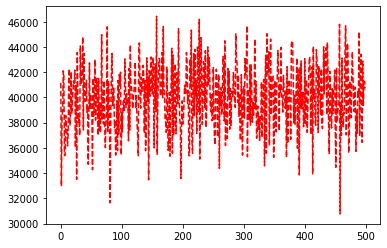

In [12]:
import matplotlib.pyplot as plt
plt.plot(cek1, cek2, 'r--')
plt.show()

In [193]:
Q = np.loadtxt('Q.txt')
Q

array([[0.        , 0.4975    , 0.5       , 0.4975    , 0.46617668,
        0.48868905, 0.49072531, 0.495125  , 0.495125  , 0.5       ,
        0.495125  , 0.45000905, 0.5       , 0.5       , 0.45      ,
        0.45      ],
       [0.5       , 0.        , 0.5       , 0.5       , 0.5       ,
        0.4975    , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.        , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , 0.        , 0.5       ,
        0.4975    , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.        ,
        0.5       , 0.5       , 

In [144]:
distance[0]

array([    0.,  2724.,  2588.,  3262.,  3705.,  4575.,  2474.,  3532.,
        3287.,  2700.,  1393.,  1760.,  2462.,  2755.,  4179.,  4147.,
        3574.,  3435.,  3555.,  3810.,  4335.,   587.,  1860.,  2232.,
        2953.,  3105.,  1597.,  8713.,  9035.,  9854., 10331.,  6660.,
        6766.,  5268.,  4671.,  4169.,  5850.,  4711.,  4991.,  4771.,
        3741., 13308., 12804.,  4326.,  3899.,  3860.,  4857.,  5221.,
        3882.,  3763.,  3617.])